In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Cálculo A2max, rmax, phimax vs tiempo - GADGET

In [5]:
import numpy as np
import h5py
import rotation_mio as rot
import barstrength2 as strng
import time_conversion as tiempo
import bines2 as bines

h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter

vector = ('00','01','03')
vector3 = ('M31','MW','M33')
vector2= ('blue', 'red', 'green')


path = '/home/omarioni/'
atime = np.loadtxt(path + 'redshift_outputs.txt')
aexp = atime[:,2]


path = '/mnt/is2/alejandro/ornella/'

snapshot=range(496,50,-1)
for isnap in snapshot:
    snap = h5py.File(path+'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
#     print isnap
    
    for i in range(0,3):
        cm   = snap['subhalo_0'+ str('%s' %vector[i])+ '/Center'].value
        r200 = snap['subhalo_0'+ str('%s' %vector[i])+ '/R200'].value

        pstr = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Coordinates'].value
        mstr = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Masses'].value
        vel  = snap['subhalo_0'+ str('%s' %vector[i])+ '/Str/Velocities'].value

        z = a0/aexp[isnap] - 1.
        Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
        time = tiempo.conv(z, h, omega_lambda, omega_matter)
        
#---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
        ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
        zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
        r = np.sqrt(xstr**2+ystr**2+zstr**2)
         
        v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
        v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
        v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.
        
#----------------------masas----------------------------
        mstr = mstr/h
        
        r200 = r200*aexp[isnap]/h
        
        rgal=0.15*r200
        
        limit = np.where(r < rgal)
        r_sort = np.sort(r[limit])
        r_indice = np.argsort(r[limit])
        
        Mc_str = np.cumsum((mstr[limit])[r_indice])
        M_gal = Mc_str[-1]
        
#------------------ calculamos M90------------------------------------------
        razon = Mc_str/M_gal
        noventa, = np.where(razon < 0.9)
        cincuenta, = np.where(razon < 0.5)
        
        r50 = r_sort[cincuenta][-1]
#         M90 = Mc_str[noventa]                

#-------------------------------------------------------------------            
        corte,=np.where(r<3*aexp[isnap])
        veloc,=np.where(r<r50)
        
#----------componentes de la velocidad del centro de masa------------
        vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
        vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
        vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])
        
#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
        vx = v_x - vxcm
        vy = v_y - vycm
        vz = v_z - vzcm
        
        e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])

        xn = e1x*xstr + e1y*ystr + e1z*zstr
        yn = e2x*xstr + e2y*ystr + e2z*zstr
        zn = e3x*xstr + e3y*ystr + e3z*zstr
        vxn = e1x*vx + e1y*vy + e1z*vz
        vyn = e2x*vx + e2y*vy + e2z*vz
        vzn = e3x*vx + e3y*vy + e3z*vz
        
        
        A2max, rmax, phimax = strng.a2max(mstr[corte], xn[corte], yn[corte], 20)
#         print 'phimax=', phimax, 'A2max=', A2max, 'rbinmax=', rmax
#--------------------------------------------------------------------------------------------------------------------
        path2 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/'
        archivo1 =  open(path2 + str('%s'%vector3[i])+'_A2max_time_test1.dat','a')
        archivo1.write(str('%12.6f'% aexp[isnap]) +'\t'+
                 str('%12.6f'% time) +'\t'+
                 str('%12.6f'% A2max) +'\t'+
                 str('%12.6f'% phimax) +'\t'+
                 str('%12.6f'% rmax) +'\n')
        archivo1.close()

#archivo _new es el nuevo con las rotaciones bien hechas

## Cálculo A2max, rmax, phimax vs tiempo - GASOLINE

In [6]:
import h5py
import rotation_mio as rot
import barstrength2 as strng

a0=1

vector = (1,2,4)
vector2 = ('M31', 'MW','M33')

#path = 'home/ornela/SimCLUES/'
path = '/mnt/sersic2/omarioni/'

snapshot = np.loadtxt(path + 'Gasoline/snapshots.txt', dtype='string')


for j in range(len(snapshot)-1,0,-1):
    snap = h5py.File(path + 'Gasoline/outputs2/snap_'+str('%s'%snapshot[j])+'.h5py', 'r')

#     print snapshot[j]

    for i in range(0,3):
        cm   = snap['subhalo_00'+ str('%s' %vector[i])+ '/Center'].value
        r200 = snap['subhalo_00'+ str('%s' %vector[i])+ '/R200'].value
        time = snap['subhalo_00'+ str('%s' %vector[i])+ '/Time'].value
        h    = snap['subhalo_00'+ str('%s' %vector[i])+ '/h'].value
        aexp = snap['subhalo_00'+ str('%s' %vector[i])+ '/aexp'].value

        pstr = snap['subhalo_00'+ str('%s' %vector[i]) + '/Str/Coordinates'].value
        mstr = snap['subhalo_00'+ str('%s' %vector[i]) + '/Str/Masses'].value
        vel  = snap['subhalo_00'+ str('%s' %vector[i])+ '/Str/Velocities'].value

#---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = pstr[:,0]-cm[0]
        ystr = pstr[:,1]-cm[1]
        zstr = pstr[:,2]-cm[2]
        r = np.sqrt(xstr**2+ystr**2+zstr**2)

#------------------------------------------------
        r200 = r200*aexp
        rgal=0.15*r200

        limit = np.where(r<rgal)
        r_sort = np.sort(r[limit])
        r_indice = np.argsort(r[limit])


        Mc_str = np.cumsum((mstr[limit])[r_indice])
        M_gal = Mc_str[-1]

#------------------ calculamos M90------------------------------------------
        razon = Mc_str/M_gal
        noventa, = np.where(razon < 0.9)
        cincuenta, = np.where(razon < 0.5)

        r90 = r_sort[noventa][-1]
        r50 = r_sort[cincuenta][-1]
        M90 = Mc_str[noventa]                

#-------------------------------------------------------------------            
        corte,=np.where(r<3*aexp)
        veloc,=np.where(r<r50)

#----------componentes de la velocidad del centro de masa------------
        vxcm = sum(mstr[veloc]*vel[veloc,0])/sum(mstr[veloc])
        vycm = sum(mstr[veloc]*vel[veloc,1])/sum(mstr[veloc])
        vzcm = sum(mstr[veloc]*vel[veloc,2])/sum(mstr[veloc])

#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
        vx = vel[:,0] - vxcm
        vy = vel[:,1] - vycm
        vz = vel[:,2] - vzcm

        e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp)

        xn = e1x*xstr + e1y*ystr + e1z*zstr
        yn = e2x*xstr + e2y*ystr + e2z*zstr
        zn = e3x*xstr + e3y*ystr + e3z*zstr
        vxn = e1x*vx + e1y*vy + e1z*vz
        vyn = e2x*vx + e2y*vy + e2z*vz
        vzn = e3x*vx + e3y*vy + e3z*vz


        A2max, rmax, phimax = strng.a2max(mstr[corte], xn[corte], yn[corte], 20)
        
#--------------------------------------------------------------------------------------------------------------------

        path2 = '/home/omarioni/Barras_GdGs/Barras_Gs/_data/'
        archivo1 =  open(path2 + str('%s'%vector2[i])+'_A2max_time_test1.dat','a')
        archivo1.write(str('%12.6f'% aexp) +'\t'+
                 str('%12.6f'% time) +'\t'+
                 str('%12.6f'% A2max) +'\t'+
                 str('%12.6f'% phimax) +'\t'+
                 str('%12.6f'% rmax) +'\n')
        archivo1.close()
        
#archivo _new es el nuevo con las rotaciones bien hechas

In [2]:
# path = '/home/ornela/PYTHON/'
import numpy as np

path = '/home/omarioni/'
M31_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M31_A2max_time_test1.dat')
aexp_M31gd  = M31_gd[:,0]
time_M31gd  = M31_gd[:,1]
A2max_M31gd = M31_gd[:,2]
phim_M31gd  = M31_gd[:,3]
rmax_M31gd  = M31_gd[:,4]

#------------------------------------------------------------------------------------------

MW_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/MW_A2max_time_test1.dat')
aexp_MWgd  = MW_gd[:,0]
time_MWgd  = MW_gd[:,1]
A2max_MWgd = MW_gd[:,2]
phim_MWgd  = MW_gd[:,3]
rmax_MWgd  = MW_gd[:,4]

#------------------------------------------------------------------------------------------

M33_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M33_A2max_time_test1.dat')
aexp_M33gd  = M33_gd[:,0]
time_M33gd  = M33_gd[:,1]
A2max_M33gd = M33_gd[:,2]
phim_M33gd  = M33_gd[:,3]
rmax_M33gd  = M33_gd[:,4]

#------------------------------------------------------------------------------------------

M31_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M31_A2max_time_test1.dat')
aexp_M31gs  = M31_gs[:,0]
time_M31gs  = M31_gs[:,1]
A2max_M31gs = M31_gs[:,2]
phim_M31gs  = M31_gs[:,3]
rmax_M31gs  = M31_gs[:,4]

#------------------------------------------------------------------------------------------
MW_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/MW_A2max_time_test1.dat')
aexp_MWgs  = MW_gs[:,0]
time_MWgs  = MW_gs[:,1]
A2max_MWgs = MW_gs[:,2]
phim_MWgs  = MW_gs[:,3]
rmax_MWgs  = MW_gs[:,4]

#------------------------------------------------------------------------------------------

M33_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M33_A2max_time_test1.dat')
aexp_M33gs  = M33_gs[:,0]
time_M33gs  = M33_gs[:,1]
A2max_M33gs = M33_gs[:,2]
phim_M33gs  = M33_gs[:,3]
rmax_M33gs  = M33_gs[:,4]


### Datos del viejo omega_bar

In [3]:
# path = '/home/ornela/PYTHON/Barras_GdGs/Barras_Gd_/barras/'
path = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/'
cm = np.loadtxt(path + 'new_phi_time.dat')
time =cm[:,1]
phi =cm[:,2]

kk = len(phi)-1

delta_phi = np.zeros(len(phi))
delta_t = np.zeros(len(phi))
tt = np.zeros(len(phi))

for i in range(kk,0,-1):
    delta_t [i]  = time[i-1] - time[i]
    delta_phi[i] = phi[i-1] - phi[i]
    tt[i] = (time[i-1] + time[i]) / 2.

delta_t   = delta_t[1:]
delta_phi = delta_phi[1:]
tt = tt[1:]

veloc_ang = delta_phi/delta_t
velocang = veloc_ang/360.

In [3]:
path = '/home/omarioni/'
M31_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M31_lbarvstime2.dat')
time0_M31gd = M31_gd[:,0][-1]
print time0_M31gd
#------------------------------------------------------------------------------------------
M31_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M31_lbarvstime.dat')
time0_M31gs = M31_gs[:,0][-1]
print time0_M31gs

#------------------------------------------------------------------------------------------
MW_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/MW_lbarvstime.dat')
time0_MWgs = MW_gs[:,0][-1]
print time0_MWgs


8.623489
8.159224
10.730151


## Graficamos A2max vs time

Acá vamos a hacer los dataframe para poder hacer el running mean

In [5]:
import pandas as pd
df1 = pd.DataFrame({'A2max': A2max_M31gd[::-1]})
df2 = pd.DataFrame({'A2max': A2max_MWgd[::-1]})
df3 = pd.DataFrame({'A2max': A2max_M33gd[::-1]})
df4 = pd.DataFrame({'A2max': A2max_M31gs[::-1]})
df5 = pd.DataFrame({'A2max': A2max_MWgs[::-1]})
df6 = pd.DataFrame({'A2max': A2max_M33gs[::-1]})

# print df1

In [134]:
prueba1=df1.rolling(7, win_type='triang').mean()
prueba2=df2.rolling(7, win_type='triang').mean()
prueba3=df3.rolling(7, win_type='triang').mean()
prueba4=df4.rolling(2, win_type='triang').mean()
prueba5=df5.rolling(2, win_type='triang').mean()
prueba6=df6.rolling(2, win_type='triang').mean()

# print shape(prueba)
# print prueba2['A2max']

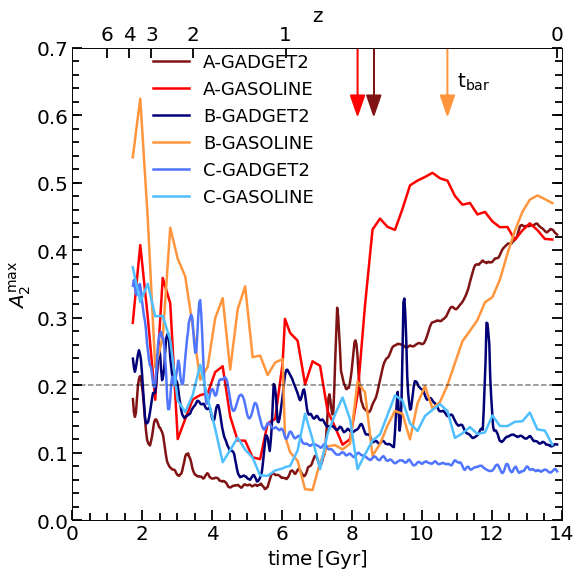

In [138]:
import matplotlib.pyplot as plt
import time_conversion as tiempo
from matplotlib.ticker import AutoMinorLocator
# from __future__ import unicode_literals

# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['text.latex.unicode'] = True
h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True
#                        gridspec_kw = {'height_ratios':[3,1,3,1]}
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.97, top = 0.92)

# ax.plot(time_M31gd ,A2max_M31gd,'-', lw=2.5, color='#801414', label='A-GADGET2')
# ax.plot(time_M31gs ,A2max_M31gs,'-', lw=2.5, color='#FF0000', label='A-GASOLINE')
# ax.plot(time_MWgd  ,A2max_MWgd, '-', lw=2.5, color='#020076', label='B-GADGET2')
# ax.plot(time_MWgs  ,A2max_MWgs, '-', lw=2.5, color='#FF963E', label='B-GASOLINE')
# ax.plot(time_M33gd ,A2max_M33gd,'-', lw=2.5, color='#5075FE', label='C-GADGET2')
# ax.plot(time_M33gs ,A2max_M33gs,'-', lw=2.5, color='#4FBFFF', label='C-GASOLINE')


ax.plot(time_M31gd[::-1] ,prueba1['A2max'],'-', lw=2.5, color='#801414', label='A-GADGET2')
ax.plot(time_M31gs[::-1] ,prueba4['A2max'],'-', lw=2.5, color='#FF0000', label='A-GASOLINE')
ax.plot(time_MWgd[::-1]  ,prueba2['A2max'], '-', lw=2.5, color='#020076', label='B-GADGET2')
ax.plot(time_MWgs[::-1]  ,prueba5['A2max'], '-', lw=2.5, color='#FF963E', label='B-GASOLINE')
ax.plot(time_M33gd[::-1] ,prueba3['A2max'],'-', lw=2.5, color='#5075FE', label='C-GADGET2')
ax.plot(time_M33gs[::-1] ,prueba6['A2max'],'-', lw=2.5, color='#4FBFFF', label='C-GASOLINE')

ax.set_ylabel(r'$A_{2}^{\mathrm{max}}$', fontsize=20)
ax.set_xlabel(r'$\mathrm{time\:[Gyr]}$',fontsize=20)
ax.set_xticks([0,2,4,6,8,10,12,14])
# ax.yaxis.set_major_locator(MultipleLocator(0.1))
# ax.yaxis.set_major_formatter(NullFormatter())
# ax.set_yticklabels(['','','$0.1$','','$0.3$','','$0.5$','','$0.7$'])
# ax.axes.ticklabel_format(style='sci')
ax.set_ylim(0,0.7)
ax.set_xlim(0,14)
ax.minorticks_on()
ax.tick_params( labelsize=20)
ax.tick_params('both', length=7, width=1.8,which='minor', direction='in', right='on',top='off')
ax.tick_params('both', length=10, width=1.8,which='major', direction='in', right='on',top='off')

# ax.yaxis.set_minor_locator(MultipleLocator(0.025)) 
ax.axhline(y=0.2,ls='--',lw=1.5, color='k', alpha=0.5)
ax.arrow(x=time0_M31gd,y=0.7,dx=0,dy=-0.1,color='#801414', lw=1.5,
         head_length=0.03,head_width=0.4,length_includes_head=True)
ax.arrow(x=time0_M31gs,y=0.7,dx=0,dy=-0.1,color='#FF0000', lw=1.5,
         head_length=0.03,head_width=0.4,length_includes_head=True)
ax.arrow(x=time0_MWgs,y=0.7,dx=0,dy=-0.1,color='#FF963E', lw=1.5,
         head_length=0.03,head_width=0.4,length_includes_head=True)

ax.legend(fontsize=18,frameon=False, loc=(0.15,0.65))
ax.text(11,0.65, '$\mathrm{t_\mathrm{bar}}$', fontsize=20, ha='left',va='center')


ax2 = ax.twiny()
new_tick_label = np.array([6,4,3,2,1,0])
ticks_pos = tiempo.conv(new_tick_label, h, omega_lambda, omega_matter)
ax2.set_xticks(ticks_pos)
ax2.set_xlim(ax.get_xlim())
ax2.set_xticklabels(new_tick_label)
ax2.set_xlabel('z',fontsize=20)
ax2.tick_params( labelsize=20)
ax2.tick_params('both', length=7, width=1.8,which='minor', direction='in', right='on',top='on')
ax2.tick_params('both', length=10, width=1.8,which='major', direction='in', right='on',top='on')

# ax3 = ax.twiny()
# z =1./aexp_M31gd -1

# new_tick_label = np.array([3.5,2.5,1.5,0.5])

# ticks_pos = tiempo.conv(new_tick_label, h, omega_lambda, omega_matter)
# # ax2.plot(z[::-1],prueba1['A2max'],'k')
# ax3.set_xlim(ax.get_xlim())
# ax3.set_xticks(ticks_pos)
# ax3.set_xticklabels([])
# ax3.tick_params('both', length=7, width=1.8,which='major', direction='in', right='on',top='on')


# fig.savefig('/home/ornela/overleaf/13216980csjxswjndpmj/A2max_time.pdf', dpi = 100, xxbox_inches='tight')
fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/A2max_time_conz.pdf', dpi = 100, xxbox_inches='tight')

plt.show()

In [76]:
print z.max(), aexp_M31gd.min(), time_M31gd.min()

4.13347022587269 0.1948 1.562627


In [77]:
1./0.1948 -1

4.13347022587269

## A2max vs Fdisk

In [19]:
path = '/home/omarioni/'
M31_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M31_fdisk_time.dat')
fdisk_M31gd   = M31_gd[:,1]

#-------------------------------------------------------------------------------
MW_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/MW_fdisk_time.dat')
fdisk_MWgd   = MW_gd[:,1]

#-------------------------------------------------------------------------------
M33_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M33_fdisk_time.dat')
fdisk_M33gd   = M33_gd[:,1]

#-------------------------------------------------------------------------------
M31_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M31_fdisk_time.dat')
fdisk_M31gs   = M31_gs[:,1]

#-------------------------------------------------------------------------------
MW_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/MW_fdisk_time.dat')
fdisk_MWgs   = MW_gs[:,1]

#-------------------------------------------------------------------------------
M33_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M33_fdisk_time.dat')
fdisk_M33gs   = M33_gs[:,1]

In [15]:
Mtot_M31gd = Mdm50_M31gd/M50_M31gd + Mg50_M31gd/M50_M31gd + 1.
Mtot_M31gs = Mdm50_M31gs/M50_M31gs + Mg50_M31gs/M50_M31gs + 1.
Mtot_MWgd  = Mdm50_MWgd/M50_MWgd   + Mg50_MWgd/M50_MWgd   + 1.
Mtot_MWgs  = Mdm50_MWgs/M50_MWgs   + Mg50_MWgs/M50_MWgs   + 1.
Mtot_M33gd = Mdm50_M33gd/M50_M33gd + Mg50_M33gd/M50_M33gd + 1.
Mtot_M33gs = Mdm50_M33gs/M50_M33gs + Mg50_M33gs/M50_M33gs + 1.

In [ ]:
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True
#                        gridspec_kw = {'height_ratios':[3,1,3,1]}
fig.subplots_adjust(bottom=0.08, left =0.1, right = 0.9, top = 0.95, wspace=0., hspace= 0)

ax.plot(A2max_M31gd, fdisk_M31gd ,'.', color='red')
# ax.plot(A2max_MWgd[:len(Mtot_MWgd)],   Mtot_MWgd/np.sqrt(2.)  ,'.', color='navy')
# ax.plot(A2max_M33gd[:len(Mtot_M33gd)], Mtot_M33gd/np.sqrt(2.) ,'.', color='b')
# ax.plot(A2max_M31gs[:len(Mtot_M31gs)], Mtot_M31gs/np.sqrt(2.) ,'.', color='fuchsia')
# ax.plot(A2max_MWgs[:len(Mtot_MWgs)],   Mtot_MWgs/np.sqrt(2.)  ,'.', color='hotpink')
# ax.plot(A2max_M33gs[:len(Mtot_M33gs)], Mtot_M33gs/np.sqrt(2.) ,'.', color='dodgerblue')

ax.set_xlabel(r'$A_{2}^{\mathrm{max}}$', fontsize=40)
ax.set_ylabel(r'$f_{\mathrm{disk}}$',fontsize=40)
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xticks([0,2,4,6,8,10,12,14])
# ax.yaxis.set_major_locator(MultipleLocator(0.1))
# ax.yaxis.set_major_formatter(NullFormatter())
# ax.set_yticklabels(['','','$0.1$','','$0.3$','','$0.5$','','$0.7$'])
# ax.axes.ticklabel_format(style='sci')
# ax.set_ylim(0,0.8)
# ax.set_xlim(0,14)
ax.minorticks_on()
ax.tick_params( labelsize=40)
ax.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax.yaxis.set_minor_locator(MultipleLocator(0.025)) 
# ax.axhline(y=0.2,ls='--',lw=1.5, color='k', alpha=0.5)
# ax.arrow(x=time0_M31gd,y=0.8,dx=0,dy=-0.1,color='red', lw=1.5,
#          head_length=0.03,head_width=0.3,length_includes_head=True)
# ax.arrow(x=time0_M31gs,y=0.8,dx=0,dy=-0.1,color='fuchsia', lw=1.5,
#          head_length=0.03,head_width=0.3,length_includes_head=True)
# ax.arrow(x=time0_MWgs,y=0.8,dx=0,dy=-0.1,color='hotpink', lw=1.5,
#          head_length=0.03,head_width=0.3,length_includes_head=True)


# fig.savefig('/home/ornela/overleaf/13216980csjxswjndpmj/A2max_time.pdf', dpi = 100, xxbox_inches='tight')
# fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/A2max_time_new.pdf', dpi = 100, xxbox_inches='tight')

plt.show()

In [19]:
print len(Mtot_M31gd)

472


## phi vs time

In [33]:
print phim_M31gd1[0]/2

0.8300135


In [57]:
fig=plt.figure(1, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax=fig.add_subplot(111)
ax.plot(time_M31gd, phim_M31gd,'k-', lw=1)
# ax.set_xlim(7.5,14)
ax.set_xlim(13,14)
ax.minorticks_on()
ax.tick_params(labelsize=24)
ax.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on')
ax.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on')
# ax.set_facecolor('silver')
# ax.grid(color='w',linestyle=':',which='major')
#ax.grid(color='lightgray',linestyle=':',which='minor')
ax.set_xlabel(r'$tiempo\:[Gyr]$', fontsize=30)
ax.set_ylabel(r'$\phi_{bar}$',fontsize=30)
#ax3.axis('square') #hace el plot cuadrado

# fig.savefig('/home/ornela/Dropbox/AAA_2017/escrito/BAAA_2018_art/fig_04.pdf', dpi = 100)
plt.show()

In [80]:
mask, = np.where(time_M31gd > time0_M31gd) 
time_M31gd1 = time_M31gd[mask]
phim_M31gd1 = phim_M31gd[mask]

plt.plot(time_M31gd1, phim_M31gd1)
plt.xlim(13,14)

In [78]:
phicum = np.zeros(len(phim_M31gd1))
phicum[0]= phim_M31gd1[0]
print phim_M31gd1

for i in range(1,len(phim_M31gd1)):
#     print phicum[i-1]
    aux = abs(phim_M31gd1[i]-phicum[i-1])
    if aux > np.pi/2.:
        phicum[i] = np.pi/2.+phim_M31gd1[i]
    else:
        phicum[i] = phim_M31gd1[i]
#     print phicum[i]

    
plt.plot(time_M31gd1, phicum)
plt.xlim(12,14)

In [19]:
mask, = np.where(time_M31gd > time0_M31gd) 
time_M31gd1 = time_M31gd[mask]
phim_M31gd1 = phim_M31gd[mask]
        
ang = np.zeros(len(phim_M31gd1))
ang[-1] = phim_M31gd1[-1]

j = 1
kk = len(phim_M31gd1)-1

for i in range(kk,0,-1):
    aux = phim_M31gd12[i] - phim_M31gd12[i-1]
    
    if aux > 0:
        ang[i-1] = phim_M31gd12[i-1] + 360*j
        j += 1
        
    else:
        ang[i-1] = phim_M31gd12[i-1] + 360*(j-1)
        
ajuste = np.polyfit(time_M31gd12, ang, deg = 5)
print ajuste

def func(x):
    a = ajuste[0]
    b = ajuste[1]
    c = ajuste[2]
    d = ajuste[3]
    e = ajuste[4]
    f = ajuste[5]
    
    func = a*x**5 + b*x**4 + c*x**3 + d*x**2 + e*x + f
    return func

fig=plt.figure(1, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax=fig.add_subplot(111)
ax.plot(time_M31gd12, ang,'ko', markersize=5)
ax.plot(time_M31gd12, func(time_M31gd12),'-r', lw=2)
# ax.plot()
# ax.set_xlim(7.5,14)
# ax.set_ylim(8,18)
ax.minorticks_on()
ax.tick_params(labelsize=24)
ax.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on')
ax.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on')
# ax.set_facecolor('silver')
# ax.grid(color='w',linestyle=':',which='major')
#ax.grid(color='lightgray',linestyle=':',which='minor')
ax.set_xlabel(r'$tiempo\:[Gyr]$', fontsize=30)
ax.set_ylabel(r'$\phi_{bar}$',fontsize=30)
#ax3.axis('square') #hace el plot cuadrado

# fig.savefig('/home/ornela/Dropbox/AAA_2017/escrito/BAAA_2018_art/fig_04.pdf', dpi = 100)
plt.show()

In [20]:
def derivada(x):
    a = ajuste[0]
    b = ajuste[1]
    c = ajuste[2]
    d = ajuste[3]
    e = ajuste[4]
    f = ajuste[5]
    
    derivada = a*5*x**4 + b*4*x**3 + c*3*x**2 + d*2*x + e
    
    return derivada

fig=plt.figure(1, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax=fig.add_subplot(111)
ax.plot(time_M31gd12, derivada(time_M31gd12),'k-', lw=2)
# ax.set_xlim(7.5,14)
# ax.set_ylim(8,18)
# ax.spines['bottom'].set_color('w')
# ax.spines['top'].set_color('w')
# ax.spines['left'].set_color('w')
# ax.spines['right'].set_color('w')
ax.minorticks_on()
ax.tick_params(labelsize=24)#, colors=('lightgray')
ax.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on')#,colors='w'
ax.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on')#,colors='w' 
# ax.set_facecolor('silver')
# ax.grid(color='w',linestyle=':',which='major')
#ax.grid(color='lightgray',linestyle=':',which='minor')
ax.set_xlabel(r'$tiempo\:[Gyr]$', fontsize=30)#, color='lightgray'
ax.set_ylabel(r'$\Omega_{bar}$',fontsize=30)#, color='lightgray'
#ax3.twinx() #me hace un eje del otro lado
#ax3.axis('square') #hace el plot cuadrado
#ax3.set_axisbelow(True)
# fig.savefig('/home/ornela/Dropbox/AAA_2017/escrito/BAAA_2018_art/fig_04.pdf', dpi = 100)
plt.show()

In [7]:
# mask, = np.where(time_M31gd1 > 6.8) 
# time_M31gd1 = time_M31gd1[mask]
# phim_M31gd1 = phim_M31gd1[mask]
        
# ang = np.zeros(len(phim_M31gd1))
# ang[-1] = phim_M31gd1[-1]

# j = 1
# kk = len(phim_M31gd1)-1

# for i in range(kk,0,-1):
#     aux = phim_M31gd1[i] - phim_M31gd1[i-1]
    
#     if aux > 0:
#         ang[i-1] = phim_M31gd1[i-1] + 360*j
#         j += 1
        
#     else:
#         ang[i-1] = phim_M31gd1[i-1] + 360*(j-1)
        
kk = len(ang)-1

delta_phi = np.zeros(len(ang))
delta_t = np.zeros(len(ang))
tt = np.zeros(len(ang))

for i in range(kk,0,-1):
    delta_t [i]  = time_M31gd12[i-1] - time_M31gd12[i]
    delta_phi[i] = ang[i-1] - ang[i]
    tt[i] = (time_M31gd12[i-1] + time_M31gd12[i]) / 2.

delta_t   = delta_t[1:]
delta_phi = delta_phi[1:]
tt = tt[1:]

veloc_ang = delta_phi/delta_t

#-------------------------------------------------------------------------------------
# d = np.ndarray([np.size(tt),2])
# d[:,0] = tt
# d[:,1] = veloc_ang

# np.savetxt('/home/ornela/python/barras/derivada_phi_time.dat', d, fmt=('%12.6f', '%12.6f'))
#-------------------------------------------------------------------------------------

fig=plt.figure(1, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax=fig.add_subplot(111)
ax.plot(tt, veloc_ang/360.,'k-', lw=2)
# ax.set_xlim(7.5,14)
# ax.set_ylim(8,18)
# ax.spines['bottom'].set_color('w')
# ax.spines['top'].set_color('w')
# ax.spines['left'].set_color('w')
# ax.spines['right'].set_color('w')
ax.minorticks_on()
ax.tick_params(labelsize=24)#, colors='lightgray'
ax.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on')#,colors='w'
ax.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on')#,colors='w'  
# ax.set_facecolor('silver')
# ax.grid(color='w',linestyle=':',which='major')
#ax.grid(color='lightgray',linestyle=':',which='minor')
ax.set_xlabel(r'$tiempo\:[Gyr]$', fontsize=30)#, color='lightgray'
ax.set_ylabel(r'$\Omega_{bar}$',fontsize=30)#, color='lightgray'
#ax3.twinx() #me hace un eje del otro lado
#ax3.axis('square') #hace el plot cuadrado
#ax3.set_axisbelow(True)
# fig.savefig('/home/ornela/Dropbox/AAA_2017/escrito/BAAA_2018_art/fig_04.pdf', dpi = 100)
plt.show()

## Graficamos Rmax vs tiempo

In [17]:
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16),sharey=True)
#                        gridspec_kw = {'height_ratios':[3,1,3,1]}
fig.subplots_adjust(bottom=0.08, left =0.1, right = 0.95, top = 0.95, wspace=0., hspace= 0)

ax[0,0].plot(time_M31gd ,rmax_M31gd,'-', lw=2, color='k')
# ax[0,0].plot(time_M31gd2 ,A2max_M31gd2,'-', lw=3, color='r')
ax[0,0].set_ylabel(r'$R^{max}$', fontsize=40)
ax[0,0].set_xticks([2,4,6,8,10,12,14])
ax[0,0].set_xticklabels([])
# ax[0,0].set_yticks([8,9,10,11,12])
# ax[0,0].set_xticklabels([])
# ax[0,0].set_ylim(8,12.5)
ax[0,0].set_xlim(2,14)
ax[0,0].minorticks_on()
ax[0,0].tick_params( labelsize=40)
ax[0,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[0,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')

# ax[0,0].text(2.5, 0.65, 'GADGET-M31', fontsize=30, color='k', ha='left', va='center')

#------------------------------------------------------

# ax2=fig.add_subplot(222)
ax[0,1].plot(time_M31gs ,rmax_M31gs,'-', lw=2, color='k')
# ax[0,1].plot(time_M31gs2 ,A2max_M31gs2,'-',lw=3, color='r')
# ax[0,1].set_xticks([2,4,6,8,10,12,14])
# ax[0,1].set_xticklabels([])
# ax[0,1].set_yticklabels([])
# ax[0,0].set_ylim(0,0.5)
ax[0,1].set_xlim(2,14)
ax[0,1].minorticks_on()
ax[0,1].tick_params( labelsize=40)
ax[0,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[0,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')

# ax[0,1].text(2.5, 0.65, 'GASOLINE-M31', fontsize=30, color='k', ha='left', va='center')

# # #---------------------------------------------------------

# ax3=fig.add_subplot(223)
ax[1,0].plot(time_MWgd ,rmax_MWgd,'-', lw=2, color='k')
# ax[1,0].plot(time_MWgd2 ,A2max_MWgd2,'-', lw=3, color='r')

ax[1,0].set_xticks([2,4,6,8,10,12])
ax[1,0].set_ylabel(r'$R^{max}$', fontsize=40)
ax[1,0].set_xlabel(r'$time\:[Gyr]$', fontsize=40)
ax[1,0].set_xlim(2,14)
ax[1,0].minorticks_on()
ax[1,0].tick_params( labelsize=40)
ax[1,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[1,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')

# ax[1,0].text(2.5, 0.65, 'GADGET-MW', fontsize=30, color='k', ha='left', va='center')


# # #---------------------------------------------------------------------------------------
# # ax4=fig.add_subplot(224)
ax[1,1].plot(time_MWgs ,rmax_MWgs,'-', lw=2, color='k')
# ax[1,1].plot(time_MWgs2 ,A2max_MWgs2,'-', lw=3, color='r')
ax[1,1].set_xticks([2,4,6,8,10,12,14])
ax[1,1].set_xlabel(r'$time\:[Gyr]$', fontsize=40)
ax[1,1].set_xlim(2,14)
ax[1,1].minorticks_on()
ax[1,1].tick_params( labelsize=40)
ax[1,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[1,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')

# ax[1,1].text(2.5, 0.65, 'GASOLINE-MW', fontsize=30, color='k', ha='left', va='center')

# fig.savefig('/home/ornela/Dropbox/Presentacion_graficos/Rmax_time.png', dpi = 100, xxbox_inches='tight')

plt.show()